# Seattle Road Weather Information Stations
This notebook works with the <a href="https://www.kaggle.com/city-of-seattle/seattle-road-weather-information-stations">Seattle Road Weather Information Stations</a> dataset on Kaggle. The data is collected from sensor stations placed on bridges and streets that measures the temperature of road surface and air.

The goal for this notebook is to solve a **regression problem** by build and train regression models that can learn to predict the surface road temperature based on other features in the dataset. The evaluation metrics for performance  will be **root mean squared error (RMSE)** and **R-sqaured score**.

In [1]:
%matplotlib inline

import numpy as np
import pandas as pd
from pandas import get_dummies
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.metrics import r2_score, mean_squared_error

In [3]:
df = pd.read_csv('datasets/seattle-road-weather/road-weather-information-stations.csv')

---
## Data Understanding and Exploration

In [4]:
df.head(3)

,StationName,StationLocation,DateTime,RecordId,RoadSurfaceTemperature,AirTemperature
0,SpokaneSwingBridge,"{'type': 'Point', 'coordinates': [-122.351743,...",2019-09-18T02:02:00.000,3500793,57.45,61.86
1,NE45StViaduct,"{'type': 'Point', 'coordinates': [-122.301929,...",2019-09-18T15:12:00.000,3594561,78.25,68.40
2,AlbroPlaceAirportWay,"{'type': 'Point', 'coordinates': [-122.314114,...",2019-09-17T02:17:00.000,451479,18.76,27.24


The dataset contains 6 features:
<ul>
    <li>StationsName: name of the road weather sensor stations.</li>
    <li>StationLocation: location of the road weather stations, in the tuple form of latitude-longitude .</li>
    <li>DataTime: record date and time.</li>
    <li>RecordId: record ID.</li>
    <li>RoadSurfaceTemperature: temperature of the road surface in degree Fahrenheit.</li>
    <li>AirTemperature: air temperature in degree Fahrenheit.</li>
</ul>

In [5]:
df.isna().sum()

StationName               0
StationLocation           0
DateTime                  0
RecordId                  0
RoadSurfaceTemperature    0
AirTemperature            0
dtype: int64

There is no missing values in this dataset, so we don't have to worry about dropping nulls or imputation.

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1447982 entries, 0 to 1447981
Data columns (total 6 columns):
 #   Column                  Non-Null Count    Dtype  
---  ------                  --------------    -----  
 0   StationName             1447982 non-null  object 
 1   StationLocation         1447982 non-null  object 
 2   DateTime                1447982 non-null  object 
 3   RecordId                1447982 non-null  int64  
 4   RoadSurfaceTemperature  1447982 non-null  float64
 5   AirTemperature          1447982 non-null  float64
dtypes: float64(2), int64(1), object(3)
memory usage: 66.3+ MB


In [7]:
df['StationName'].value_counts()

RooseveltWay_NE80thSt        237053
35thAveSW_SWMyrtleSt         236735
NE45StViaduct                235075
AlbroPlaceAirportWay         231265
AuroraBridge                 228280
MagnoliaBridge               220474
HarborAveUpperNorthBridge     40706
SpokaneSwingBridge            18394
Name: StationName, dtype: int64

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


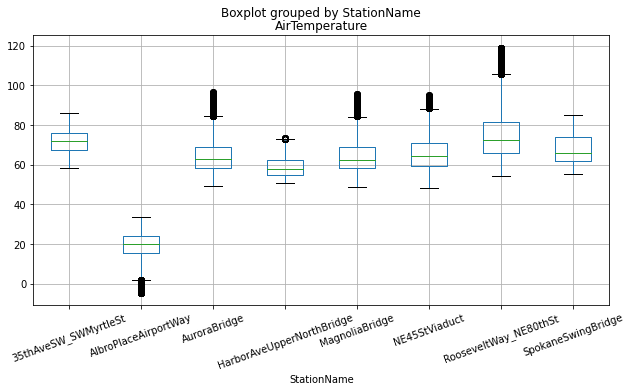

In [8]:
df.boxplot('AirTemperature', by='StationName', figsize=(10, 5))
plt.xticks(rotation=20);

C:\ProgramData\Anaconda3\lib\site-packages\numpy\core\_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


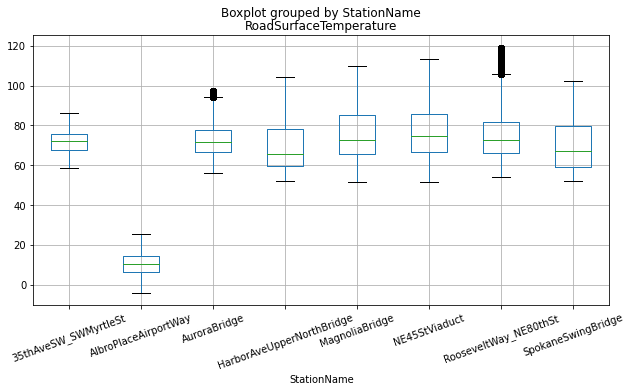

In [9]:
df.boxplot('RoadSurfaceTemperature', by='StationName', figsize=(10, 5))
plt.xticks(rotation=20);

There are 8 road weather information stations. From the box plots, we can find that the Albro Place Airport Way sensor station has the lowest air and road surface temperature of all in this dataset.

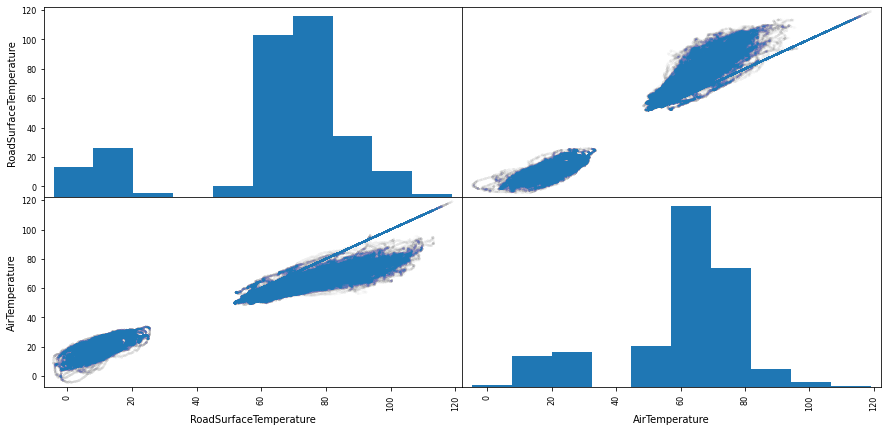

In [10]:
pd.plotting.scatter_matrix(df[['RoadSurfaceTemperature', 'AirTemperature']], figsize=(15,7), alpha=5e-3);

We can see that there's a high correlation between road surface temperature and air temperature.

---
## Data Preprocessing
### StationName
Because the StationName feature is stored as an object, in order for linear regression model to learn, we have to apply one-hot encoding to it.

In [11]:
df_station = pd.get_dummies(df['StationName'])
df_station.head(3)

,35thAveSW_SWMyrtleSt,AlbroPlaceAirportWay,AuroraBridge,HarborAveUpperNorthBridge,MagnoliaBridge,NE45StViaduct,RooseveltWay_NE80thSt,SpokaneSwingBridge
0,0,0,0,0,0,0,0,1
1,0,0,0,0,0,1,0,0
2,0,1,0,0,0,0,0,0


In [12]:
# Perform left join to merge the dataframes
df = df.join(df_station)

In [13]:
df.head(3)

,StationName,StationLocation,DateTime,RecordId,RoadSurfaceTemperature,AirTemperature,35thAveSW_SWMyrtleSt,AlbroPlaceAirportWay,AuroraBridge,HarborAveUpperNorthBridge,MagnoliaBridge,NE45StViaduct,RooseveltWay_NE80thSt,SpokaneSwingBridge
0,SpokaneSwingBridge,"{'type': 'Point', 'coordinates': [-122.351743,...",2019-09-18T02:02:00.000,3500793,57.45,61.86,0,0,0,0,0,0,0,1
1,NE45StViaduct,"{'type': 'Point', 'coordinates': [-122.301929,...",2019-09-18T15:12:00.000,3594561,78.25,68.40,0,0,0,0,0,1,0,0
2,AlbroPlaceAirportWay,"{'type': 'Point', 'coordinates': [-122.314114,...",2019-09-17T02:17:00.000,451479,18.76,27.24,0,1,0,0,0,0,0,0


In [14]:
# Generate a correlation matrix after the one-hot encoding
corr = df.drop('RecordId', axis=1).corr()
corr

,RoadSurfaceTemperature,AirTemperature,35thAveSW_SWMyrtleSt,AlbroPlaceAirportWay,AuroraBridge,HarborAveUpperNorthBridge,MagnoliaBridge,NE45StViaduct,RooseveltWay_NE80thSt,SpokaneSwingBridge
RoadSurfaceTemperature,1.000000,0.954846,0.135753,-0.913173,0.144069,0.039166,0.191153,0.220444,0.194951,0.029030
AirTemperature,0.954846,1.000000,0.258299,-0.886500,0.080586,-0.010874,0.080184,0.119442,0.334153,0.046199
35thAveSW_SWMyrtleSt,0.135753,0.258299,1.000000,-0.192741,-0.191259,-0.075189,-0.187362,-0.194628,-0.195604,-0.050147
AlbroPlaceAirportWay,-0.913173,-0.886500,-0.192741,1.000000,-0.188611,-0.074148,-0.184768,-0.191933,-0.192896,-0.049453
AuroraBridge,0.144069,0.080586,-0.191259,-0.188611,1.000000,-0.073578,-0.183347,-0.190457,-0.191413,-0.049073
HarborAveUpperNorthBridge,0.039166,-0.010874,-0.075189,-0.074148,-0.073578,1.000000,-0.072079,-0.074874,-0.075249,-0.019292
MagnoliaBridge,0.191153,0.080184,-0.187362,-0.184768,-0.183347,-0.072079,1.000000,-0.186576,-0.187512,-0.048073
NE45StViaduct,0.220444,0.119442,-0.194628,-0.191933,-0.190457,-0.074874,-0.186576,1.000000,-0.194784,-0.049937
RooseveltWay_NE80thSt,0.194951,0.334153,-0.195604,-0.192896,-0.191413,-0.075249,-0.187512,-0.194784,1.000000,-0.050188
SpokaneSwingBridge,0.029030,0.046199,-0.050147,-0.049453,-0.049073,-0.019292,-0.048073,-0.049937,-0.050188,1.000000


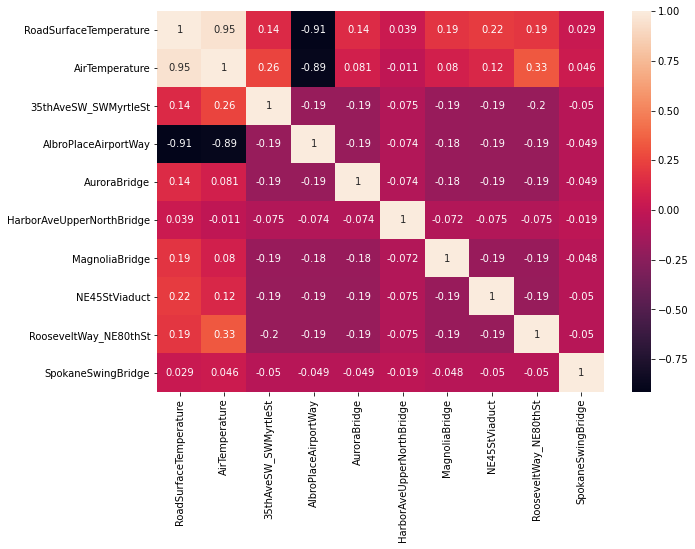

In [15]:
# Show the correlation matrix visually as a heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(corr, annot=True);

We can observe that there's a strong correlation between road surface temperature and air temperature (close to 1). Interestingly, the Albro Place Airport Way station also has a strong but negative correlation to the two temperature measures. For all other sensor stations, there appear to have low to neglegiable correlation to our target feature of road surface temperature.

---
## Training and Evaluating Model
In this section of the notebook, we will be training and evaluating 4 models: linear regression, ridge, lasso, and elastic net. The models will learn on training set and evaluated on the testing set, and their predictions will be evaluated using RMSE and R-squared score.

The target feature will be the road surface temperature, and the learning features are the station names (after one-hot encoded) and the air temperature collected by the sensor stations.

In [16]:
drop_labels = ['StationName', 'StationLocation', 'DateTime', 'RecordId', 'RoadSurfaceTemperature']

# Keep only the station name and air temperature for learning features
X = df.drop(drop_labels, axis=1)
y = df['RoadSurfaceTemperature']

In [17]:
# Perform train-test split with 80-20% ratio
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

#### Linear Regression

In [18]:
clf = LinearRegression()
clf.fit(X_train, y_train)

LinearRegression()

In [19]:
y_pred = clf.predict(X_test)

In [20]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test RMSE: ', rmse)

Test RMSE:  4.6669740518016845


In [21]:
r2_score(y_test, y_pred)

0.9667357266012668

#### Ridge Regression

In [22]:
param_grid = [{
    'alpha': [1, 1e-1, 1e-2, 1e-3, 1e-4]
}]

clf = Ridge()

# Use grid search to find best alpha
grid_search = GridSearchCV(clf, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           return_train_score=True)

grid_search.fit(X_train, y_train);

In [23]:
#clf = Ridge(alpha=1e-4, random_state=42)
#clf.fit(X_train, y_train)

In [24]:
grid_search.best_params_

{'alpha': 0.1}

In [25]:
best_clf = grid_search.best_estimator_
best_clf.fit(X_train, y_train)

Ridge(alpha=0.1)

In [26]:
y_pred = best_clf.predict(X_test)

In [27]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test RMSE: ', rmse)

Test RMSE:  4.6669731188767845


In [28]:
r2_score(y_test, y_pred)

0.9667357399002763

#### Lasso Regression

In [29]:
from sklearn.linear_model import Lasso

clf = Lasso(alpha=1e-6)
clf.fit(X_train, y_train)

Lasso(alpha=1e-06)

In [30]:
y_pred = clf.predict(X_test)

In [31]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test RMSE: ', rmse)

Test RMSE:  4.666973121388365


In [32]:
r2_score(y_test, y_pred)

0.9667357398644733

#### Elastic Net

In [33]:
clf = ElasticNet(alpha=1e-3, max_iter=4000)
clf.fit(X_train, y_train)

ElasticNet(alpha=0.001, max_iter=4000)

In [34]:
y_pred = clf.predict(X_test)

In [35]:
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)

print('Test RMSE: ', rmse)

Test RMSE:  4.6670913187762135


In [36]:
r2_score(y_test, y_pred)

0.9667340549186452

---
### Brief Conclusion
As we can observe from each model's RMSE and R-squared score, **they all provide somewhat equivalent performance on this dataset**, with a RMSE of around 4.67 degree Fahrenheit and a R-squared score of 0.9667. Thus, any of the models can be said to perform well.

This actually isn't a surprising result, given that we have already observed **(1)** the strong correlation between the two temperature measures and **(2)** the weak correlation between most sensor stations to the target feature. The predictions could simply be a reflection of the road surface temperature's close relation to the air temperature feature.